### Imports

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx

import folium
import branca.colormap as cmap # a folium spin-off for colormapping.

In [2]:
# Generate a random seed for reproducibility
seed = 42
import random
random.seed(seed)

### Simulation
The rules of the simulation are as follows:
- Each timestep t represents a day. We simulate for each Agent the course of one day
- Each agent represents a person living at a specific residence in Eindhoven
- Each agent has a list of amenity types that they visit regularly and a probability that they will visit it on any given day.
- Each agent can either walk or cycle to work. They randomly choose whether they walk or cycle each day.
- Some agents have a workplace. This can be one of the amenity types. They will always go to the same workplace with a high probability on each day.
- For the amenities they don’t work at, an agent keeps a list of the closest n amenities to their home or workplace, and go to one of those on the list based on a geometrically decreasing probability in order of proximity. We name this probability "curiosity".

In [3]:
# Initialization
# About everything required is cached to files
# If the files are not found, the code will download the data
# and save it to the files
# This takes a while
import person as ps

G = ps.dists.G_bike
# Get the nodes and edges of the graph
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Adapted from eindhovenMap.py
tags = {
    'office': True,
    'amenity': [
        'pharmacy', 'hospital', 'clinic', 'doctors', 
        'school', 'kindergarten', 'college', 'university',  
        'cafe', 'restaurant', 'bar', 'cinema', 'theatre',  
        'community_centre', 'library', 'bicycle_rental',
        'place_of_worship', 
    ],
    'leisure': [
        'park', 'fitness_centre', 'sports_centre', 'stadium', 
        'dog_park', 'pitch', 'swimming_pool'
    ]
}

residences = ps.dists.residences
offices = ps.dists.offices
amenities = ps.dists.amenities
workplaces = ps.dists.workplaces

print(f"Number of residences: {len(residences)}")

print(f"Number of offices: {len(offices)}")

print(f"Number of amenities: {len(amenities)}")

print(f"Number of workplaces: {len(workplaces)}")


Loading networks v4
Loading networks from files...
Loading data from amenities.pickle...
Loading data from offices.pickle...
Loading data from residences.pickle...
Loading data from pois.pickle...
                                   geometry     amenity  check_date  \
element id                                                            
node    36723712    POINT (5.4875 51.44781)     library  2025-03-03   
        84201162   POINT (5.47758 51.43648)  restaurant         NaN   
        119209139  POINT (5.48072 51.44084)      cinema         NaN   
        230103591  POINT (5.45656 51.47743)         NaN         NaN   
        250852374  POINT (5.52632 51.44886)      school         NaN   

                  check_date:opening_hours internet_access level  \
element id                                                         
node    36723712                2025-03-03            wlan  -1;0   
        84201162                       NaN             NaN   NaN   
        119209139                

### Prep

We have a map of Eindhoven where we can sample two nodes: a randomly-chosen residence and randomly-chosen amenity. We can map the route between them with ox using matplotlib as backend. 

74156
703


c:\Users\euseb\AppData\Local\Programs\Python\Python313\Lib\site-packages\osmnx\plot.py:351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(od_x, od_y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


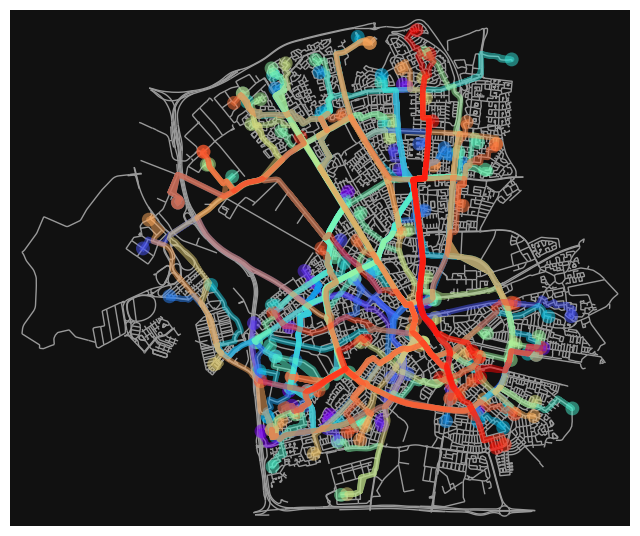

42606637
42619800
                                                             geometry amenity  \
element id                                                                      
node    250852374                            POINT (5.52632 51.44886)  school   
        1699991564                           POINT (5.44156 51.43905)  school   
        2713602914                            POINT (5.45368 51.4309)  school   
        2717118986                           POINT (5.45731 51.42871)  school   
        2727533688                           POINT (5.44871 51.41487)  school   
...                                                               ...     ...   
way     1228473343  POLYGON ((5.45857 51.44283, 5.45874 51.44264, ...  school   
        1229167348  POLYGON ((5.50056 51.47491, 5.50176 51.47483, ...  school   
        1239211502  POLYGON ((5.44413 51.47413, 5.4447 51.47354, 5...  school   
        1375027985  POLYGON ((5.46187 51.45422, 5.46188 51.45421, ...  school   
        13

In [ ]:
# For now just simulate a single agent
# Create a random agent

print(len(residences))
print(len(amenities))

import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

routes = []
num_routes = 10
for i in range(num_routes):
    rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]
    wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]
    orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) 
    dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=wcoords[1]) 
    route = nx.shortest_path(G, orig, dest, weight='length')
    routes.append(route)

# Generate a list of colors from a colormap
colors = cm.rainbow(np.linspace(0, 1, num_routes))

# Plot all routes with different colors
fig, ax = ox.plot_graph_routes(
    G, 
    routes, 
    route_colors=colors, 
    route_linewidth=1, 
    node_size=0,
    show=False, 
    close=False
)
plt.show()

print(ox.distance.nearest_nodes(
    G, 
    X=rcoords[0],
    Y=rcoords[1],
))
print(ox.distance.nearest_nodes(
    G, 
    X=wcoords[0],
    Y=wcoords[1],
))

print(amenities[amenities['amenity'] == 'school'])




In [5]:
"""m = folium.Map(location=[residences.geometry.centroid.y.mean(), residences.geometry.centroid.x.mean()], zoom_start=13)

for i in range(100):
    rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]
    wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]
    orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) 
    dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=wcoords[1]) 
    route = nx.shortest_path(G, orig, dest, weight='length')
    route_nodes = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in route]
    folium.PolyLine(route_nodes, color="red", weight=2, opacity=0.7).add_to(m)

m
# Save the map to an HTML file
m.save("map.html")"""

'm = folium.Map(location=[residences.geometry.centroid.y.mean(), residences.geometry.centroid.x.mean()], zoom_start=13)\n\nfor i in range(100):\n    rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]\n    wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]\n    orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) \n    dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=wcoords[1]) \n    route = nx.shortest_path(G, orig, dest, weight=\'length\')\n    route_nodes = [(G.nodes[n][\'y\'], G.nodes[n][\'x\']) for n in route]\n    folium.PolyLine(route_nodes, color="red", weight=2, opacity=0.7).add_to(m)\n\nm\n# Save the map to an HTML file\nm.save("map.html")'

In [6]:
print(ps.dists.calculate_distances(
    ps.dists.G_walk, rcoords, wcoords
))

for i in range(100):
    agent = ps.person(
    residence_coords= rcoords, 
    work_coords= wcoords,
    walk_speed=4,
    amenity_freqs={ ('cafe', 'park'): 0.5, ('school', 'restaurant'): 0.5 },
    seed=42
    )
    #agent.simulate_day()


Start node: 12534707892, End node: 42619800
2113.7921710804612
Start node: 12534707892, End node: 42619800
Start node: 42606637, End node: 42619800
Distances from residence to work:
2113.7921710804612
1965.6684238575308
Initializing distances for amenities...
[0.89763057 0.09590136]
Created BallTree for tags: ('cafe', 'park')
[0.89763057 0.09590136]
[0.89763057 0.09590136]
Created BallTree for tags: ('restaurant', 'school')
[0.89763057 0.09590136]
Initializing work distances for amenities...
1
2
3
4
5
6
1
2
3
4
5
6
Start node: 12534707892, End node: 42619800
Start node: 42606637, End node: 42619800
Distances from residence to work:
2113.7921710804612
1965.6684238575308
Initializing distances for amenities...
[0.89763057 0.09590136]
[0.89763057 0.09590136]
[0.89763057 0.09590136]
[0.89763057 0.09590136]
Initializing work distances for amenities...
1
2
3
4
5
6
1
2
3
4
5
6
Start node: 12534707892, End node: 42619800
Start node: 42606637, End node: 42619800
Distances from residence to work

KeyboardInterrupt: 

In [ ]:

amenity_types = tags['amenity'] + tags['leisure']



# Function to generate random amenity frequencies
def generate_random_amenity_freqs(amenity_types):
    return {amenity: random.uniform(0.0, 1.0) for amenity in amenity_types}


# Function to create random Person objects
def create_random_persons(num_persons):
    persons = []
    for _ in range(num_persons):
        # Generate random residence and work coordinates
        residence_coords = residences.sample(1).geometry.values[0].centroid.coords[0]  # Example bounding box for Eindhoven
        work_coords = amenities.sample(1).geometry.values[0].centroid.coords[0] if random.random() < 0.8 else None  # 80% chance of having a work location
        
        # Generate random parameters
        walk_speed = random.uniform(3, 5)  # Walking speed in km/h
        bike_speed = random.uniform(8, 12)  # Biking speed in km/h
        bike_freq = random.uniform(0.0, 1.0)  # Frequency of biking
        work_freq = random.uniform(0.0, 1.0)  # Frequency of going to work
        curiosity = random.uniform(0.5, 1.0)  # Curiosity level
        amenity_freqs = generate_random_amenity_freqs(amenity_types)  # Random amenity frequencies
        
        # Create a Person object
        person = ps.person(
            residence_coords=residence_coords,
            work_coords=work_coords,
            walk_speed=walk_speed,
            bike_speed=bike_speed,
            bike_freq=bike_freq,
            work_freq=work_freq,
            amenity_freqs=amenity_freqs,
            curiosity=curiosity,
            seed=seed
        )
        persons.append(person)
    return persons

def create_random_persons_nofreqs(num_persons):
    persons = []
    print("Residences: ", len(residences))
    print("Amenities: ", len(amenities))

    residences_samples = residences.sample(num_persons, replace=True)
    amenities_samples = amenities.sample(num_persons, replace=True)
    for i in range(num_persons):
        # Generate random residence coordinates
        residence_coords = residences_samples.geometry.values[i].centroid.coords[0]
        # Generate random work coordinates
        work_coords = amenities_samples.geometry.values[i].centroid.coords[0]
    
        
        # Generate random parameters
        walk_speed = random.uniform(3, 5)  # Walking speed in km/h
        bike_speed = random.uniform(8, 12)  # Biking speed in km/h
        bike_freq = random.uniform(0.0, 1.0)  # Frequency of biking
        work_freq = 1
        
        # Create a Person object
        person = ps.person(
            residence_coords=residence_coords,
            work_coords=work_coords,
            walk_speed=walk_speed,
            bike_speed=bike_speed,
            bike_freq=bike_freq,
            work_freq=work_freq,
            amenity_freqs=None,
            seed=seed
        )
        persons.append(person)
    return persons


In [ ]:


"""
random_persons = create_random_persons(10)
for i, person in enumerate(random_persons):
    print(f"Person {i+1}:")
    print(f"  Residence: {person.residence_coords}")
    print(f"  Work: {person.work_coords}")
    print(f"  Walk Speed: {person.walk_speed} km/h")
    print(f"  Bike Speed: {person.bike_speed} km/h")
    print(f"  Bike Frequency: {person.bike_freq}")
    print(f"  Work Frequency: {person.work_freq}")
    print(f"  Curiosity: {person.curiosity}")
    print(f"  Amenity Frequencies: {person.amenity_freqs}")
    print()
"""

workplace_coords=(5.476556, 51.441230)
random_persons = create_random_persons_nofreqs(100)

Residences:  3706
Amenities:  703
Start node: 1269564265, End node: 6426227731
Start node: 1269564265, End node: 6426227731
Distances from residence to work:
3076.339273215413
3076.339273215413
Start node: 42578887, End node: 61101653
Start node: 42578887, End node: 61101653
Distances from residence to work:
2981.0703437097936
2981.0703437097936
Start node: 42607514, End node: 1250611310
Start node: 42607514, End node: 1250611310
Distances from residence to work:
6431.347501515435
6431.347501515435
Start node: 42624452, End node: 42614082
Start node: 42624452, End node: 42614082
Distances from residence to work:
3961.8628394558973
3961.8628394558973
Start node: 12444405445, End node: 42568891
Start node: 12444405445, End node: 42568891
Distances from residence to work:
5025.159275044796
5025.159275044796
Start node: 42671516, End node: 42598357
Start node: 42671516, End node: 42598357
Distances from residence to work:
5085.541005206407
5085.541005206407
Start node: 42614972, End node: 

In [ ]:
# Create a DataFrame to store the data
df = pd.DataFrame(columns=['lat', 'lon', 'travel_time'])

for person in random_persons:
    # Simulate the person's day
    person.simulate_day()
    travel_time = person.work_travel_time
    lat = person.residence_coords[1]
    lon = person.residence_coords[0]


    # Append the data to the DataFrame
    df.loc[len(df)] = [lat, lon, travel_time]
    
print(df.head())


Agent is walking today.
Travel time to work: 40.024897061252496 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 41.801902442166856 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 90.18323281008544 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 55.55501373982471 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 70.46503220395724 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 37.67047403642463 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 31.31385806892655 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 39.67267271986118 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 39.69228571748113 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 73.74238095

In [ ]:
print(df.describe())
# Create a Folium map centered around the average coordinates
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=13)
# Create a colormap
colormap = cmap.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'], 
    vmin=df['travel_time'].min(), 
    vmax=df['travel_time'].max()
)
# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=5,
        color=colormap(row['travel_time']),
        fill=True,
        fill_opacity=0.6,
        popup=f"Travel Time: {row['travel_time']:.2f} min"
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)
# Save the map to an HTML file
m.save("travel_time_map.html")
# Display the map in a Jupyter notebook
m

              lat         lon  travel_time
count  100.000000  100.000000   100.000000
mean    51.445120    5.474948    42.005970
std      0.017784    0.020730    28.185124
min     51.415309    5.410552     3.442043
25%     51.433944    5.463716    18.987602
50%     51.440140    5.473752    36.455296
75%     51.452634    5.487181    66.137490
max     51.493967    5.525845   131.462813


In [ ]:
from folium.plugins import HeatMap

# Normalize the travel_time into a weight between 0 and 1 if needed
df["weight"] = df["travel_time"] / df["travel_time"].max()

heat_data = [[row["lat"], row["lon"], row["weight"]] for _, row in df.iterrows()]

# Step 4: Create the Folium map
m = folium.Map(location=[df["lat"].mean(), df["lon"].mean()], zoom_start=13)
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)
m
